In [ ]:
import os

# Create a new directory called "segmentation_results"
directory = "/content/drive/My Drive/Colab Notebooks/data/segmentation_results"
if not os.path.exists(directory):
    os.makedirs(directory)


In [ ]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [ ]:
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

# Set the root folder where the data is located
root_folder = "/content/drive/My Drive/Colab Notebooks/data"

# Define the transform to convert the images to tensors
transform = ToTensor()

# Load the training data
train_dataset = datasets.ImageFolder(root=f"{root_folder}/training_set", transform=transform)

# Load the test data
test_dataset = datasets.ImageFolder(root=f"{root_folder}/test_set", transform=transform)


In [ ]:

import cv2

import os
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
train_pixel_file = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/training_set_pixel_size_and_HC.csv")
train_pixel_file.head()
# This Dataframe will be used to extract image names hence by doing image_name + '_Annotation' we will get annotation names

,filename,pixel size,head circumference (mm)
0,1_HC.png,0.069136,44.30
1,2_HC.png,0.089659,56.81
2,3_HC.png,0.062033,68.75
3,4_HC.png,0.091291,69.00
4,5_HC.png,0.061240,59.81


# FOLLOWING CODE GENERATES MASK. DO NOT RUN THE CODE AGAIN ONCE THE MASK IS GENERATED

In [ ]:
import numpy as np
def masking(image):
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ellipse = cv2.fitEllipse(contours[0])
    return cv2.ellipse(np.zeros_like(image), ellipse, (255, 255, 255), -1)


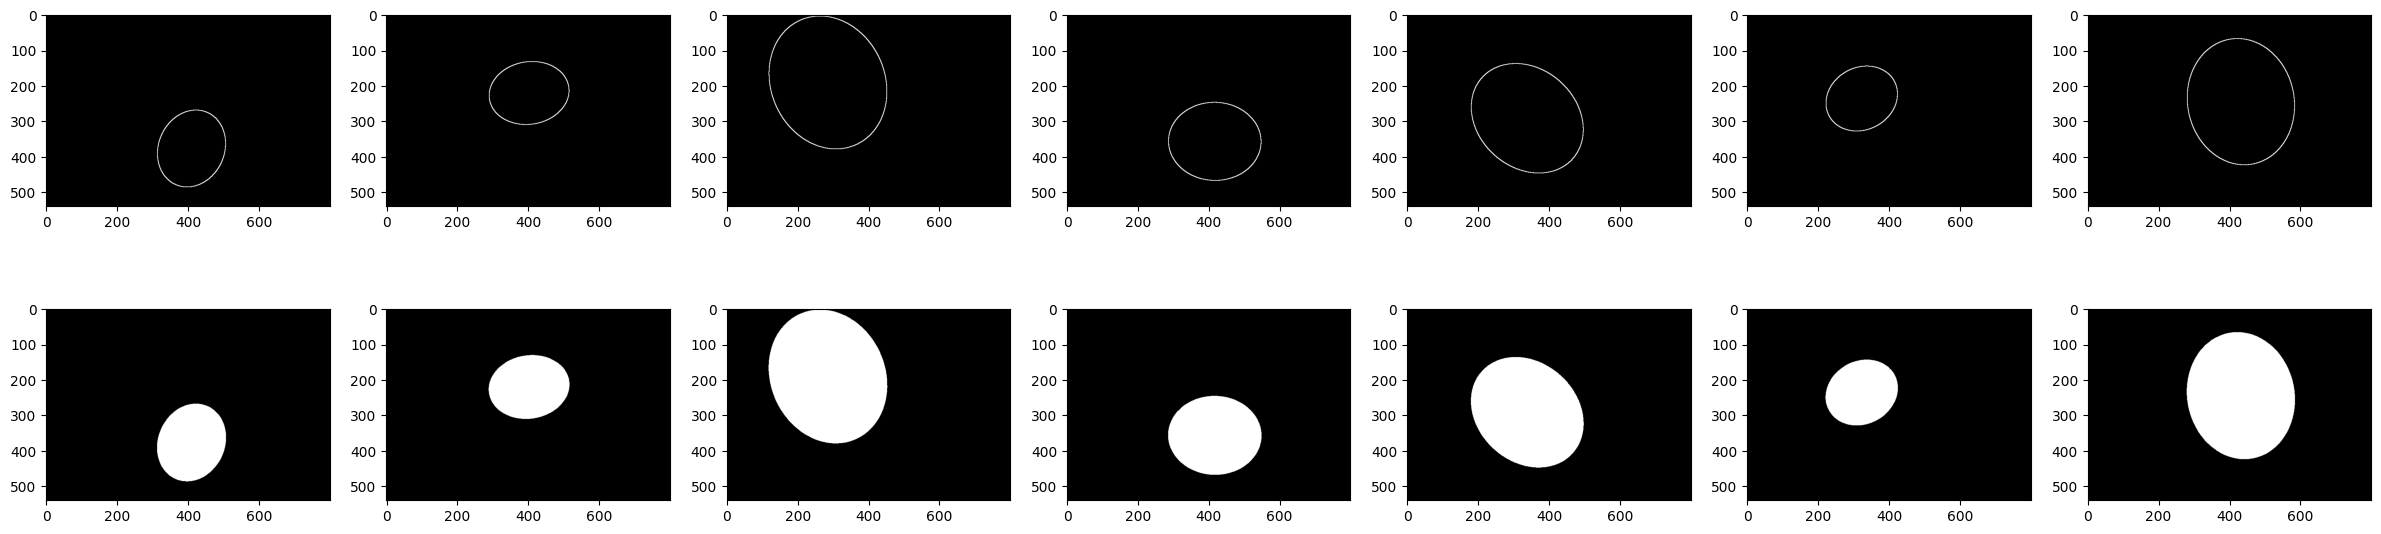

In [ ]:
# to check if our masking function is working correctly
fig = plt.figure(figsize = (30,7))
for index in range(7):
  file_path = os.path.join("/content/drive/My Drive/Colab Notebooks/data/training_set/annotations", train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
  #print(file_path)
  ax = fig.add_subplot(2, 7, index+1)             ## annoted plot
  plt.imshow(cv2.imread(file_path))
    
  ax = fig.add_subplot(2, 7, index+8)
  plt.imshow(masking(cv2.imread(file_path)))        ## mask plot

In [ ]:

# Here we loop through training set and  take annotations one by one and replace them with corresponding masks
for index in range(len(train_pixel_file)):
    file_path = os.path.join("/content/drive/My Drive/Colab Notebooks/data/training_set/annotations", train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
    image = cv2.imread(file_path)
    mask = masking(image)
    cv2.imwrite(file_path, mask)

# Mask is generated. Do not run the above code again.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from skimage import io, color
from PIL import Image
import cv2

import os
import random

import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [ ]:
validation_set_size = 0.20  
# our dataset class
class fetus(Dataset):
  #""" train and validation dataset class"""
    def __init__(self, root_dir, train = True, transformX = None, transformY = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'training_set_pixel_size_and_HC.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        
        # lets split the dataset in train and validation
        self.train_data, self.validation_data = train_test_split(self.pixel_file, test_size = validation_set_size, random_state = 5)
        
    def __len__(self):
        
        if self.train:
          length = len(self.train_data)
        else:
          length = len(self.validation_data)
        return length
    
    def __getitem__(self, index):
      
        if self.train:
          imx_name = os.path.join(self.root_dir, 'training_set/images', self.train_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'training_set/annotations',self.train_data.iloc[index, 0].replace('.png','_Annotation.png'))

        else:
          imx_name = os.path.join(self.root_dir, 'training_set/images', self.validation_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'training_set/annotations',self.validation_data.iloc[index, 0].replace('.png','_Annotation.png'))
        
        
        imx = Image.open(imx_name)
        imy = Image.open(imy_name).convert('L')
        
        ## tried some data augmentation techniques
        if self.train:
          # Random horizontal flipping
          if random.random() > 0.5:
              imx = TF.hflip(imx)
              imy = TF.hflip(imy)

          # Random vertical flipping
          if random.random() > 0.5:
              imx = TF.vflip(imx)
              imy = TF.vflip(imy)


          # Random rotation
          if random.random() > 0.8:
            angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
            imx = TF.rotate(imx, angle)
            imy = TF.rotate(imy, angle)
        
        
        
        
        
        
        if self.transformX :
            imx = self.transformX(imx)
            imy = self.transformY(imy)
        
        sample = {'image': imx, 'annotation': imy}
        return sample

In [ ]:
# datasets
tx_X = transforms.Compose([ transforms.Resize((572, 572)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                              ])
tx_Y = transforms.Compose([ transforms.Resize((572, 572)),
                              transforms.ToTensor(),  ################ no need to normalize the maskk
                             # transforms.Normalize((0.5,), (0.5,))
                              ])
train_data = fetus("/content/drive/My Drive/Colab Notebooks/data", train = True, transformX = tx_X, transformY = tx_Y)
validation_data = fetus("/content/drive/My Drive/Colab Notebooks/data", train = False, transformX = tx_X, transformY = tx_Y )

In [ ]:
# dataloaders
train_loader = DataLoader(dataset = train_data, batch_size = 2, shuffle = True, num_workers = 0)
validation_loader = DataLoader(dataset = validation_data, batch_size = 2, shuffle = True, num_workers = 0)

In [ ]:
# this function will return numpy array from the transformed tensors which were
# obtained from our train_loader.
def im_converterX(tensor):
    image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy as we will need original later
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
 # print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # unnormalizing the image # this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

In [ ]:

def im_converterY(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1,2,0) 
 # print(image.shape)
    image = image * np.array((1, 1, 1)) 
    image = image.clip(0, 1) 
    return image

0 torch.Size([2, 1, 572, 572]) torch.Size([2, 1, 572, 572])


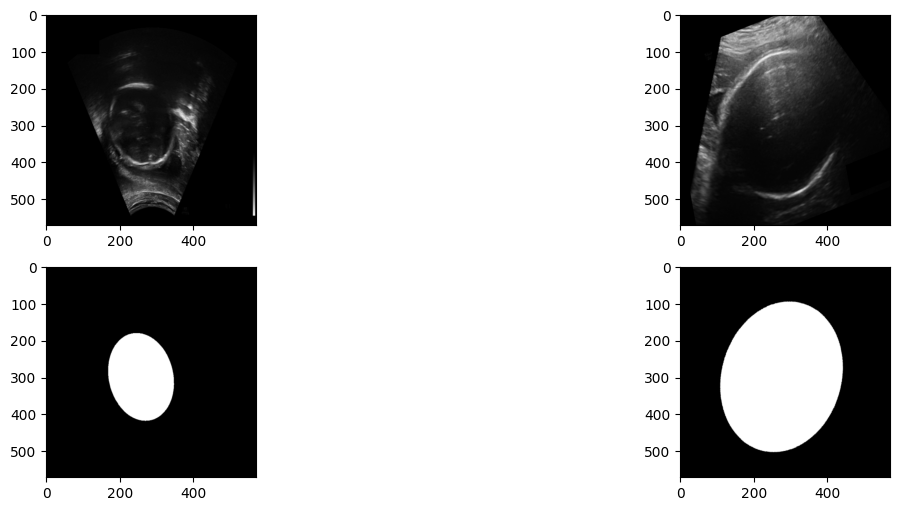

In [ ]:
## Here we loop through our train_loader and see the images

fig = plt.figure(figsize = (15,6))
for ith_batch, sample_batched in enumerate(train_loader):
    print(ith_batch, sample_batched['image'].size(), sample_batched['annotation'].size())
    
    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(sample_batched['image'][index]))
        ax = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(sample_batched['annotation'][index]))
    break

In [ ]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.7),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.77),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear: #upsampling will not be learnable
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
        else:  # it will be learnable here
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, bilinear = False) # upsampling weights are made learnable
        self.up2 = up(512, 128, bilinear = False)
        self.up3 = up(256, 64, bilinear = False)
        self.up4 = up(128, 64, bilinear = False)
        self.outc = outconv(64, n_classes)
        self.dropout = torch.nn.Dropout2d(0.5)

    def forward(self, x):
        x = x.float()
        x1 = self.inc(x)
        x2 = self.down1(x1)
       # x2 = self.dropout(x2)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.dropout(x)
        x = self.up3(x, x2)
        #x = self.dropout(x) #
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)
      
      
      
      
      
      
model = UNet(1, 1)
model.to('cuda')
print("Model Loaded to GPU")

Model Loaded to GPU


In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0077)

In [ ]:
# calculates similarity index between predicted and actual segmentation
def dice_index(y_pred, y_actual):
    smooth = 0.000001
    size_of_batch = y_pred.size(0)
    
    p1 = y_pred.view(size_of_batch, -1)
    p2 = y_actual.view(size_of_batch, -1)
    
    intersection = (p1 * p2).sum()
    
    dice =  ((2.0 * intersection )+ smooth) / (p1.sum() + p2.sum() + smooth)
    #dice.requires_grad = True
    
    return dice

In [ ]:
# calculate dice loss which will be later used in loss function calculation
def dice_loss(y_predict, y_train): ## to add in bce looss
  
  dice_loss = 1 -(dice_index(y_predict, y_train))
  
  return dice_loss
  

In [ ]:
epochs = 10


train_running_loss_history = []
validation_running_loss_history =[]

for e in range(epochs):
  train_running_loss = 0.0
  validation_running_loss = 0.0
  
  model.train()
  
  for ith_batch, sample_batched in enumerate(train_loader):
    X_train = sample_batched['image'].to('cuda')
    y_train = sample_batched['annotation'].to('cuda')
    
    #X_train.requires_grad = True
    #y_train.requires_grad = True

    #print(ith_batch) #, X_train.size(), y_train.size())

    optimizer.zero_grad()
    y_pred = model(X_train)
   # out = (y_pred + 0.5).int().float()
    
    loss = 0.30 * dice_loss(y_pred, y_train) +  0.70 * criterion(y_pred, y_train)
    #loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    if ith_batch % 50 == 0:
      print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Current Loss: ', loss.item())
      
    train_running_loss += loss.item()
    
    
    
    
  else:
    with torch.no_grad():
      
      model.eval()
      
      for ith_batch, sample_batched in enumerate(validation_loader):
          X_val = sample_batched['image'].to('cuda')
          y_val = sample_batched['annotation'].to('cuda')
          
          
          
          y_out = model(X_val)
          out_val = (y_out + 0.5).int().float()
          
          val_loss = 0.3 * dice_loss(out_val, y_val)  + 0.7 * criterion(y_out, y_val)
          
          #val_loss = criterion(y_out, y_val)
          
          validation_running_loss += val_loss.item()
      print("================================================================================")
      print("Epoch {} completed".format(e + 1))
      
      train_epoch_loss = train_running_loss / len(train_loader)
      validation_epoch_loss = validation_running_loss / len(validation_loader)
      
      print("Average train loss is {}: ".format(train_epoch_loss))
      print("Average validation loss is {}".format(validation_epoch_loss))
      print("================================================================================")
      train_running_loss_history.append(train_epoch_loss)
      validation_running_loss_history.append(validation_epoch_loss)
  
  torch.cuda.empty_cache()
      #print(y_pred.shape)

    #y_pred = y_pred.to('cpu')
    #X_train = X_train.to('cpu')

    #del y_train
    #torch.cuda.empty_cache()
    #if ith_batch ==100:
    #break
  #for index in range(2):
  #         ax = gig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
   #         plt.imshow(im_converter(X_train[index]))
    #        ax = gig.add_subplot(2, 2, index + 3)
     #       plt.imshow(im_converter(y_pred[index]))
  
    
  
   
  

  
  
  
    

Epoch:  1 Batch:  0 Current Loss:  0.6936690807342529
Epoch:  1 Batch:  50 Current Loss:  0.5249790549278259
Epoch:  1 Batch:  100 Current Loss:  0.36464500427246094
Epoch:  1 Batch:  150 Current Loss:  0.26466473937034607
Epoch:  1 Batch:  200 Current Loss:  0.33626121282577515
Epoch:  1 Batch:  250 Current Loss:  0.3954247832298279
Epoch:  1 Batch:  300 Current Loss:  0.26120004057884216
Epoch:  1 Batch:  350 Current Loss:  0.38767239451408386
Epoch 1 completed
Average train loss is 0.3759544426202774: 
Average validation loss is 0.28781931787729265
Epoch:  2 Batch:  0 Current Loss:  0.24691781401634216
Epoch:  2 Batch:  50 Current Loss:  0.29701998829841614
Epoch:  2 Batch:  100 Current Loss:  0.34513336420059204
Epoch:  2 Batch:  150 Current Loss:  0.3927425742149353
Epoch:  2 Batch:  200 Current Loss:  0.3270295262336731
Epoch:  2 Batch:  250 Current Loss:  0.314020037651062
Epoch:  2 Batch:  300 Current Loss:  0.22833459079265594
Epoch:  2 Batch:  350 Current Loss:  0.18951906263

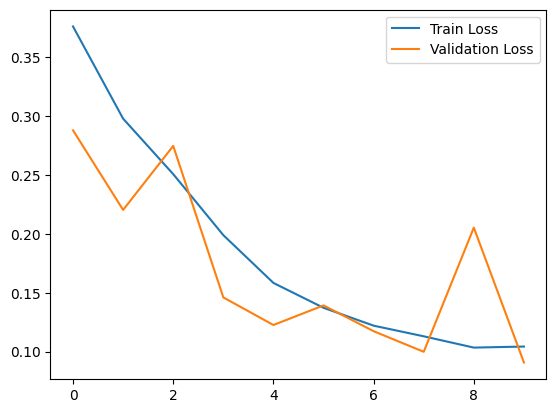

In [ ]:
plt.plot(train_running_loss_history, label = 'Train Loss')
plt.plot(validation_running_loss_history, label = 'Validation Loss')
plt.legend()

In [ ]:
model.eval()
X_train.size()

torch.Size([1, 1, 572, 572])

In [ ]:
out = (y_pred + 0.5).int().float()

In [ ]:
print(dice_index(y_train, out))
print(dice_loss(y_train, out))

tensor(0.9816, device='cuda:0')
tensor(0.0184, device='cuda:0')


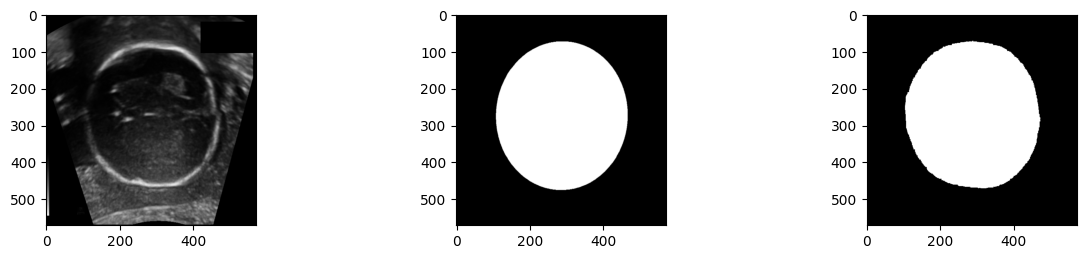

In [ ]:
pig = plt.figure(figsize = (15, 6))

a = pig.add_subplot(2, 3, 1)
plt.imshow(im_converterX(X_train[0]))

a = pig.add_subplot(2, 3, 2)
plt.imshow(im_converterY(y_train[0]))

a = pig.add_subplot(2, 3, 3)
plt.imshow(im_converterY(out[0]))




In [ ]:
class fetus_test(Dataset):
    def __init__(self, root_dir, transformX = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'test_set_pixel_size.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        
    def __len__(self):
        return len(self.pixel_file)
    
    def __getitem__(self, index):
        imx_name = os.path.join(self.root_dir, 'test_set/images', self.pixel_file.iloc[index, 0])
        
        imx = Image.open(imx_name)
        
        f_name = self.pixel_file.iloc[index, 0]
        
        if self.transformX :
            imx = self.transformX(imx)
        
        sample = {'image': imx, 'f_name': f_name}
        return sample

In [ ]:
tx_X = transforms.Compose([ transforms.Resize((572, 572)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                              ])
test_data = fetus_test("/content/drive/My Drive/Colab Notebooks/data", transformX = tx_X)

In [ ]:
test_loader = DataLoader(dataset = test_data, batch_size = 2, shuffle = True)

0 torch.Size([2, 1, 572, 572])


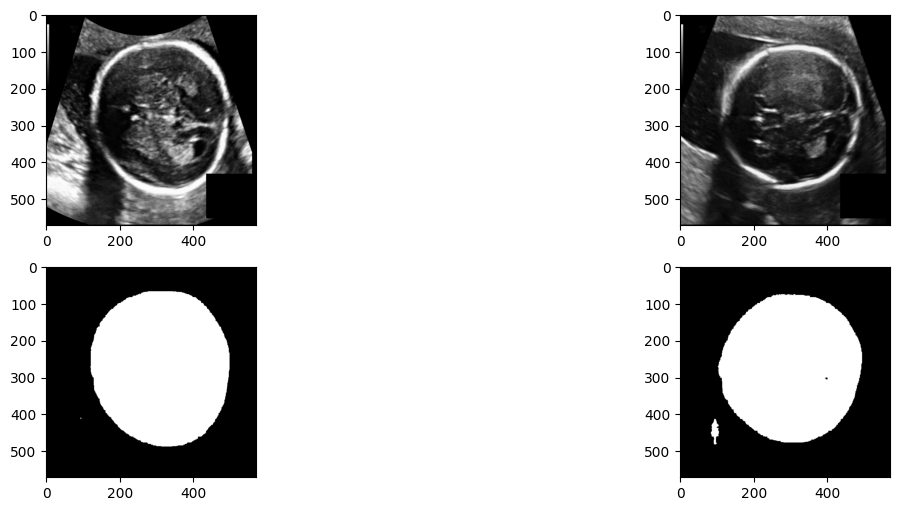

In [ ]:
## Here we loop through our train_loader and see the images
## Looks good
fig = plt.figure(figsize = (15,6))
#model.to('cpu')
for ith_batch, sample_batched in enumerate(test_loader):
  
    X_test = sample_batched['image'].to('cuda')
    print(ith_batch, X_test.size())
    
    y_test = (model(X_test) + 0.5).int().float()
    
    
    
    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(X_test[index]))
        
        ax  = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(y_test[index]))
    break

In [ ]:
def avg_dice_index(dataloader):
  
    dice = 0.0
    model.eval()
    with torch.no_grad():
    
        for ith_batch, sample_batched in enumerate(dataloader):
  
            X_train = sample_batched['image'].to('cuda')
            y_train = sample_batched['annotation'].to('cuda')
            
            y_predict = (model(X_train) + 0.5).int().float()
            
            dice += dice_index(y_predict, y_train)
            
            
            
    avg_dice = dice / len(dataloader)
    return avg_dice.item()

In [ ]:
avg_dice_index(validation_loader)    #### Dice index of validation data

0.9348538517951965

In [ ]:
avg_dice_index(train_loader)        ### Dice index of training data

0.9216706156730652

In [ ]:
test_loader = DataLoader(dataset = test_data, batch_size = 1, shuffle = True) # to write image files

#Writing data to the drive..

In [ ]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((540, 800)),
        transforms.ToTensor()
        ])
    
with torch.no_grad():
      #model.eval()
      for ith_batch , sample in enumerate(test_loader):
        X_test = sample['image'].to('cuda')
        y_pred = (model(X_test) + 0.5).int().float().cpu()
       # print(335-ith_batch)
        
        file_names = sample['f_name']
        T_Y = transform(y_pred[0])
        torchvision.utils.save_image(T_Y , os.path.join("/content/drive/My Drive/Colab Notebooks/data/segmentation_results", file_names[0]))
      print("Segmentation files written")
        
        

Segmentation files written


In [ ]:
def fit_ellipse(im):
    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        contour_sizes = [len(contour) for contour in contours]
        ellipse = cv2.fitEllipse(contours[np.argmax(contour_sizes)])
        return ellipse, contours
    else:
        return None, None


In [ ]:
df_pixel_size = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/test_set_pixel_size.csv')
submission = {'filename': [], 'center_x_mm': [], 'center_y_mm': [], 'semi_axes_a_mm': [],
             'semi_axes_b_mm': [], 'angle_rad': [], 'Index': []}

file_names = sorted([file for _,_,files in os.walk('/content/drive/My Drive/Colab Notebooks/data/segmentation_results/') for file in files])

for i, file_name in enumerate(file_names):
    im = cv2.imread('/content/drive/My Drive/Colab Notebooks/data/segmentation_results/'+file_name)
   # file_name = file_name.replace('_Segmented', '')
    ellipse = fit_ellipse(im)
    im_mask = cv2.ellipse(np.zeros_like(im),ellipse,(255,255,255),-1)
    image_name = file_name.split('.')[0] + '_Annotation_fit.png'
    cv2.imwrite('/content/drive/My Drive/Colb Notebooks/data/output_images/'+image_name, im_mask)
    
    pixel_size = df_pixel_size.loc[df_pixel_size['filename'] == file_name, 'pixel size'].iloc[0]
    submission['filename'].extend([file_name])
    submission['Index'].extend([int(file_name.split('_')[0])])
    center_x,  center_y = ellipse[0]
    submission['center_x_mm'].extend([pixel_size*center_x])
    submission['center_y_mm'].extend([pixel_size*center_y])
    semi_axes_b, semi_axes_a = ellipse[1]
    if semi_axes_b > semi_axes_a:
        semi_axes_b = semi_axes_b + semi_axes_a
        semi_axes_a = semi_axes_b - semi_axes_a
        semi_axes_b -= semi_axes_a
    submission['semi_axes_a_mm'].extend([semi_axes_a*pixel_size/2])
    submission['semi_axes_b_mm'].extend([semi_axes_b*pixel_size/2])
    angle = ellipse[2]
    if angle < 90:
        angle += 90
    else:
        angle -= 90
    submission['angle_rad'].extend([np.deg2rad(angle)])
    
submission = pd.DataFrame(submission)
submission = submission[['filename', 'center_x_mm', 'center_y_mm', 
                         'semi_axes_a_mm', 'semi_axes_b_mm', 'angle_rad', 'Index']]    
submission = submission.sort_values(['Index'])
submission = submission.drop('Index', axis=1)
submission.to_csv("/content/drive/My Drive/Colab Notebooks/data/submit_data_aug.csv", index=False)
print('Required .csv file generated')

Required .csv file generated


In [ ]:
q = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/submit_data_aug.csv")  ## to check theck the generated csv

In [ ]:
print('Length of csv file: ',len(q))

Length of csv file:  335
